# The big screen theory

##### Miri and Michael
Last edited: 21.08.2017


## Overview and Motivation
Provide an overview of the project goals and the motivation for it. Consider that this will be read by people who did not see your project proposal.

## Related Work
Anything that inspired you, such as a paper, a web site, or something we discussed in class.

## Initial Questions

Our main target was to Predict a movie's IMDB score.

For this we had to answer:

- Can we predict a movie score based on our knowledge of the movie cast, budget, facebook popularity etc...?
- Which features are more significant than others?

## Getting started with our data

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('movie_metadata.csv')
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,United Kingdom,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000


As seen above, our data initially consisted of 5000 rows, and 28 columns representing the differnt features.

___

## data preparation


We first had to perform data **cleanup** and fill in **missing values**, according to pre-defined rules such as:

| Missing value |Replace with...  |
|------|------|
| Color |blanks to "color"  |
|num_critics|0|
|   Names  | None|
|Duration| Median duration |
|Likes | 0|
|Gross\Budget | 0 |

We also **removed** samples for the following reasons:
   1. Samples of TV shows and not movies (based on content rating column).
   2. Unknown title year


In [18]:
from cleandata import clean
df = clean(df)

___

## Feature engineering

### Currency exchange and inflation compensation

Since we are dealing with movies from different countries, we found that currency columns are given in local currency, and had to be convered to USD for consistency.
In addition, a budget from 1920 cannot be compared to a 2015 budget, hence we had to compensate for the inflation over the years.
To do so, we used 2 external data sets:
   1. **An international currency exchange rate** - A data set that helped us convert the currency of each country to USD.
   2. **USD inflation values** - This data set helped us compensate to the 2016 currency. 


In [19]:
from currencyConvert import fixcurrency
df = fixcurrency(df)

### Cast gender analysis 

We wondered if the gender of the director or actors will also have an influence on our scores, so we used a **names data set**, and added a gender column for each name column.


*Note: 
We started this by using an existing API from the web, but once we finished implementing it on our data and tried to use it on the complete data set, we reached the "free limit" of the site and were blocked. This was quite frustrating, but it later made as develop the feature on our own. *


In [20]:
from names_DB_analysis import add_genders
df= add_genders(df)
df[['director_name', 'director_gender', 'actor_1_name', 'actor_1_gender', 'actor_2_name', 'actor_2_gender', 'actor_3_name', 'actor_3_gender']].head(10)

,director_name,director_gender,actor_1_name,actor_1_gender,actor_2_name,actor_2_gender,actor_3_name,actor_3_gender
0,James Cameron,Male,CCH Pounder,Unknown,Joel David Moore,Male,Wes Studi,Male
1,Gore Verbinski,Unknown,Johnny Depp,Male,Orlando Bloom,Male,Jack Davenport,Male
2,Sam Mendes,Male,Christoph Waltz,Male,Rory Kinnear,Unknown,Stephanie Sigman,Female
3,Christopher Nolan,Male,Tom Hardy,Male,Christian Bale,Male,Joseph Gordon-Levitt,Male
4,Andrew Stanton,Male,Daryl Sabara,Male,Samantha Morton,Female,Polly Walker,Female
5,Sam Raimi,Male,J.K. Simmons,Unknown,James Franco,Male,Kirsten Dunst,Female
6,Nathan Greno,Male,Brad Garrett,Male,Donna Murphy,Female,M.C. Gainey,Unknown
7,Joss Whedon,Unknown,Chris Hemsworth,Unknown,Robert Downey Jr.,Male,Scarlett Johansson,Female
8,David Yates,Male,Alan Rickman,Male,Daniel Radcliffe,Male,Rupert Grint,Male
9,Zack Snyder,Male,Henry Cavill,Male,Lauren Cohan,Female,Alan D. Purwin,Male


### Movie genre analysis

Originally, the genre column consisted of multiple genre types which made this column hard to analuse.
for example:

In [21]:
df[['movie_title', 'genres']].head(10)

,movie_title,genres
0,Avatar,Action|Adventure|Fantasy|Sci-Fi
1,Pirates of the Caribbean: At World's End,Action|Adventure|Fantasy
2,Spectre,Action|Adventure|Thriller
3,The Dark Knight Rises,Action|Thriller
4,John Carter,Action|Adventure|Sci-Fi
5,Spider-Man 3,Action|Adventure|Romance
6,Tangled,Adventure|Animation|Comedy|Family|Fantasy|Musi...
7,Avengers: Age of Ultron,Action|Adventure|Sci-Fi
8,Harry Potter and the Half-Blood Prince,Adventure|Family|Fantasy|Mystery
9,Batman v Superman: Dawn of Justice,Action|Adventure|Sci-Fi


Using a simple histogram of all genres, we identfied the top 5 genres and created added binary fields for this genres, for future analysis.

In [22]:
import features
df = features.addgenres(df)

df[['movie_title', 'genres'] + list(df.columns)[-5:]].head(10)

,movie_title,genres,isDrama,isComedy,isThriller,isAction,isRomance
0,Avatar,Action|Adventure|Fantasy|Sci-Fi,False,False,False,True,False
1,Pirates of the Caribbean: At World's End,Action|Adventure|Fantasy,False,False,False,True,False
2,Spectre,Action|Adventure|Thriller,False,False,True,True,False
3,The Dark Knight Rises,Action|Thriller,False,False,True,True,False
4,John Carter,Action|Adventure|Sci-Fi,False,False,False,True,False
5,Spider-Man 3,Action|Adventure|Romance,False,False,False,True,True
6,Tangled,Adventure|Animation|Comedy|Family|Fantasy|Musi...,False,True,False,False,True
7,Avengers: Age of Ultron,Action|Adventure|Sci-Fi,False,False,False,True,False
8,Harry Potter and the Half-Blood Prince,Adventure|Family|Fantasy|Mystery,False,False,False,False,False
9,Batman v Superman: Dawn of Justice,Action|Adventure|Sci-Fi,False,False,False,True,False


### Which movies are blockbusters

We want to see which movies are considered blockbusters, as we think this feature can contribute to our analysis.
According to wikipedia, there are 3 categories for blockbusters:
    1. High profit movie - we will decide this according to the gross column. We chose movies that earned 200 million dollar or more, based on the gross histogram (red lione in the gross histogram below)
    2. High ratio of budget/gross - would indicate 2 categories - 
        - low budget movies that earned significantly more than their budget
        - just good ROI (return of investment) movies
        We chose a gross to budget ratio of 5 for our analysis (marked in a red line in the "budget to score" part below)

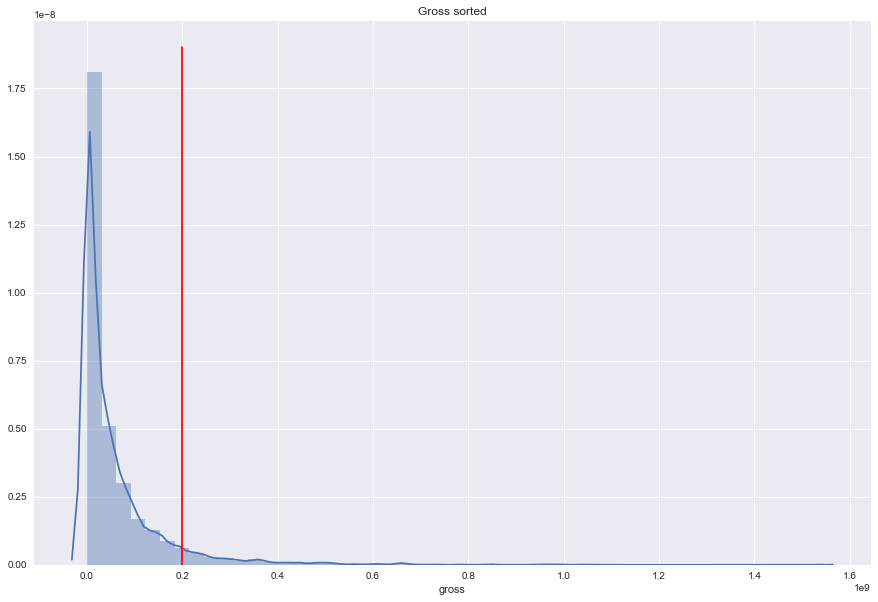

['number of high gross movies = ', 306]
['number of total blockbusters = ', 569]


In [23]:
df = features.is_blockbuster(df)

---

## Exploratory Data Analysis
What visualizations did you use to look at your data in different ways? What are the different statistical methods you considered? Justify the decisions you made, and show any major changes to your ideas. How did you reach these conclusions?

Let's get started with some intersting visualiztions.


### Facebook likes over the years

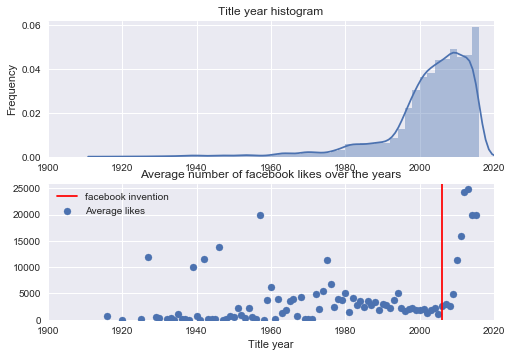

In [24]:
import basic_correlations as eda
eda.facebook_likes_over_the_years(df)

According to the simple year histogram we can note that we mainly deal with new films.
From movie facebook likes as a correlation to the year we see that obviously since the facebook was first public, the
number of likes per movie increased until it reached a certain stability.
There are some exceptions of old movies with high likes, usually "classics".

### Is there a correlation between likes and score?

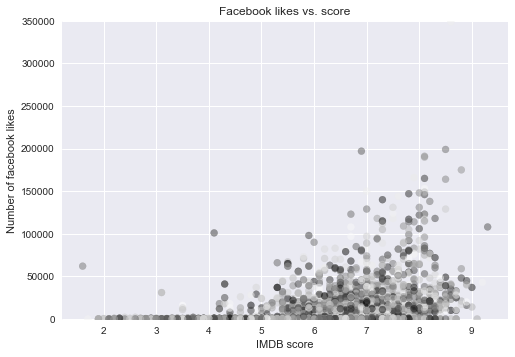

In [25]:
eda.facebook_likes_to_score(df)

we can see that the the really low score movies (below 5) really don't receive many likes, but other than that, there
seems to be no clear correlation between a high score and the number of likes.

### Is there a correlation between the budget and score?

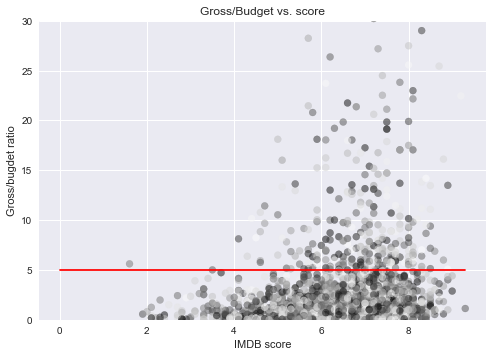

In [26]:
eda.budget_to_score(df)

### Genders influence on score

We wanted to see if male directors are better, or how does the gender of the main actor influences the movie score.

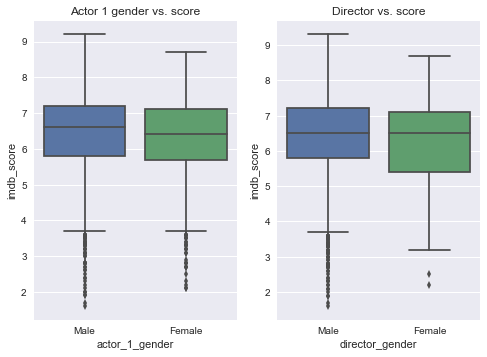

In [27]:
eda.gender_vs_score(df)

From the box plot above, we can see that there is little betweem males and females, hence we will not use it in our analysis later on.

### Feature correlation map

We chose some of the features, to see the correlation between them, for the purpose of dimensionality reduction


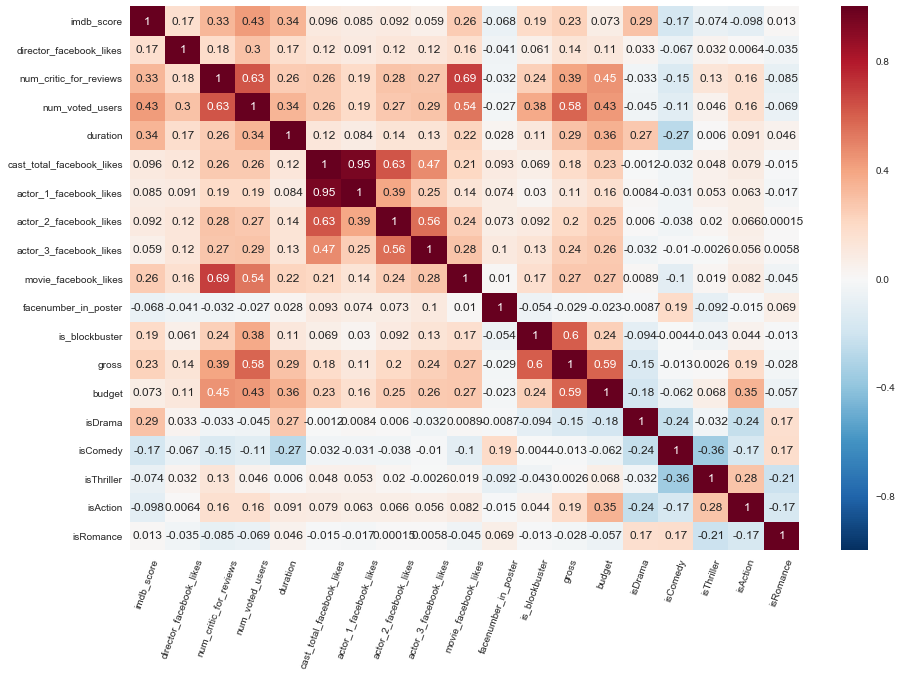

In [28]:
selectedFeatures = ['imdb_score',
                    'director_facebook_likes',
                    'num_critic_for_reviews',
                    'num_voted_users',
                    'duration',
                    'cast_total_facebook_likes',
                    'actor_1_facebook_likes',
                    'actor_2_facebook_likes',
                    'actor_3_facebook_likes',
                    'movie_facebook_likes',
                    'facenumber_in_poster',
                    'is_blockbuster',
                    'gross',
                    'budget',
                    'isDrama', 'isComedy', 'isThriller', 'isAction', 'isRomance']

plt.figure(figsize = (15,10))
sns.heatmap(df[selectedFeatures].corr(), annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=70)
plt.show()

### Observations from correlation table
- Understadably, the total of cast Facebook likes is mostly correlated to actor 1, which is the main star of the film
- The numbers of voted users and the number of facebook likes are fairly highly correlated to the number of critics, which suggests that the exposure movies get from audiance is tied to how many reviews it gets

We want to reduce our features to principal components. We will look at the explained variance.

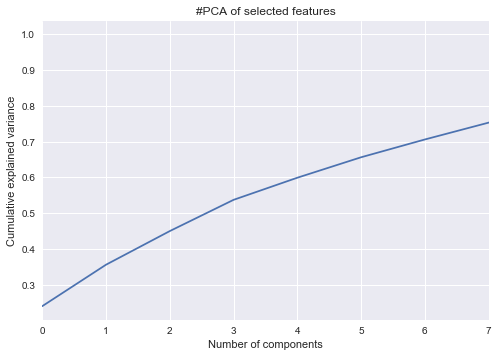

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import regressions as reg

x_train, x_test, y_train, y_test = train_test_split(
        df[selectedFeatures].drop('imdb_score', axis='columns').dropna(), df.dropna(subset=selectedFeatures, axis=0)['imdb_score'],
        test_size=0.3,
        random_state=666)
x_std = StandardScaler().fit_transform(x_train)
reg.showPca(x_std)
plt.show()

We can see that 5 PC explain 70% of the variance, so we will choose that to be the number of principal components.

## Final Analysis:    


Train error = 12.836567290037824 percent in Ridge Regression
Test error = 18.448644435590094 percent in Ridge Regression

Train error = 10.324587499515275 percent in KNN Regression
Test error = 18.401176410794772 percent in KNN Regression

Train error = 12.83886909277788 percent in Bayesian Regression
Test error = 18.424746384482972 percent in Bayesian Regression

Train error = 11.04144403015454 percent in SVM  Regression
Test error = 20.314700923768044 percent in SVM  Regression

Train error = 14.512719436437013 percent in Decision Tree  Regression
Test error = 18.301115800255648 percent in Decision Tree  Regression

Test error = 22.78985590941768 percent in Random scores



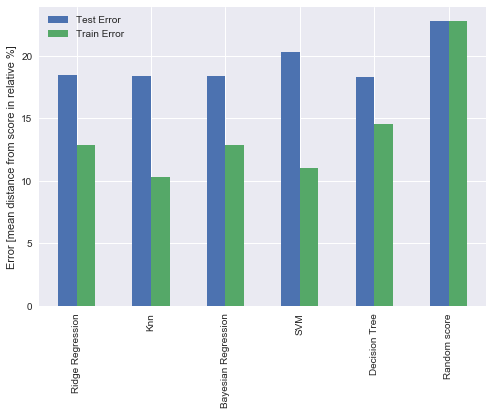

In [30]:
x_train, x_test, y_train, y_test = reg.createtesttrain(df, selectedFeatures, 5)
[ridge_train_error, ridge_test_error] = reg.doRidgeRegression(df, selectedFeatures)
[knn_train_error, knn_test_error] = reg.doKnnRegression(df, selectedFeatures, 5)
[bayes_train_error, bayes_test_error] = reg.doBayesianRegression(df, selectedFeatures)
[svm_train_error, svm_test_error] = reg.doSvmRegression(df, selectedFeatures)
[tree_train_error, tree_test_error] = reg.doDecisionTreeRegression(df, selectedFeatures)
randomscore_test = reg.randomscore(df)

train_error = [ridge_train_error, knn_train_error, bayes_train_error, svm_train_error, tree_train_error, randomscore_test]
test_error = [ridge_test_error, knn_test_error, bayes_test_error, svm_test_error, tree_test_error, randomscore_test]

col = {'Train Error': train_error,'Test Error': test_error}
models = ['Ridge Regression', 'Knn', 'Bayesian Regression', 'SVM', 'Decision Tree', 'Random score']
errors = pd.DataFrame(data=col, index=models)
errors.plot(kind='bar')
plt.ylabel('Error [mean distance from score in relative %]')
plt.show()

# Summary & Conclusions

- We aquired a database from IMDB with about 5000 samples
- The database was cleaned as described above
- Once cleaned, we proceeded to extract features aimed at answering our inital questions
- We performed EDA to better understand the data
- Finally we proceeded to try different regression modelsin attempt to predict the IMDB score based on our selected features.
    - We found decision tree regression the have the lowest test set error compared to other methods
    - However, non of the models provided a sufficent estimate of the IMDB score in terms of error
    - To further test our models, we compared a randomly generated set of IMDB scores from a Gaussian disturbation, whose model paraneters are taken from the actual scores.
    - We can see we outperform the random scores, but not by a sagnificent margin
- We can assume that the relatively small dataset hindered our results
- In addition, we saw little difference made when choosing different features, which may suggest more work is needed on feature enghineering and selection
- We can also assume thet the subjective method of scoring moveis on IMDB results in a somewhat unpredictable outcome - meaning there might a set of features the will be able to accurately predict movie scroes

